In [313]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML

***
    
    Ligação à base de dados

***

In [314]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [315]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Nome das colunas

In [316]:
def col_names(table):
    '''
    Função que retorna os nomes das colunas de uma tabela
    
    Parâmetros : 
        - table : tabela de interesse

    return : 
        - pandas DataFrame : nomes das colunas
    '''

    cur = conn.cursor()
    cur.execute('''
                SELECT column_name
                FROM information_schema.columns
                WHERE table_name = %s;''', (table,))

    cnames = pd.DataFrame(cur.fetchall())
    #cnames = [row[0] for row in cur.fetchall()]
    return cnames

HTML(pd.DataFrame(col_names('contratos')).to_html(index=True))

,0
0,id
1,n_anuncio
2,anuncio_preco_base
3,anuncio_proposalDeadline
4,anuncio_cnccs
5,anuncio_contractingProcedureAliasID
6,anuncio_contractingProcedureId
7,anuncio_drPublicationDate
8,anuncio_dreNumber
9,anuncio_dreSeries


    Número de Contratos


In [317]:
def n_contracts(table):
    '''
    Retorna o número de contratos de uma tabela pertencente à base de dados

    Parâmetros : 
        - table : tabela de interesse

    return : 
        - int : número de contrato
    '''
    
    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "{}"; '''.format(table))
    ncontract = cur.fetchone()[0]
    return ncontract

n_contracts("contratos")

19846

    Organizar Contratos por Tipo de Procedimento

In [318]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,9115
Consulta Prévia,4034
Concurso público,3605
Ao abrigo de acordo-quadro (art.º 259.º),2293
Ao abrigo de acordo-quadro (art.º 258.º),492
Ajuste direto simplificado,95
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",87
Consulta Prévia Simplificada,55
Concurso limitado por prévia qualificação,54
Procedimento de negociação,6


In [319]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,4566
Aquisição de bens móveis,3997
Empreitadas de obras públicas,383
Locação de bens móveis,71
Aquisição de serviços<br/>Aquisição de bens móveis,40
Aquisição de bens móveis<br/>Aquisição de serviços,31
Locação de bens móveis<br/>Aquisição de serviços,4
Concessão de obras públicas,4
Aquisição de serviços<br/>Locação de bens móveis,3
Aquisição de serviços<br/>Empreitadas de obras públicas,3


***

# Funções


***

    ID's dos contratos

In [320]:
def all_ids(table):
    '''
    Função que retorna todos os ids dos contratos de uma tabela

    Parâmetros :    
        - table : tabela de interesse

    Return : 
        - list : ids de todos os contratos de uma tabela 
    '''

    cur = conn.cursor()
    cur.execute(''' 
                SELECT id
                FROM "{}"; '''.format(table)) 
    return list(cur.fetchall())


ids = all_ids("contratos")

    ID's dos diferentes tipos de procedimentos

    1. Ajuste Direto Regime Geral

In [321]:
def ajuste_dir():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Ajuste Direto Regime Geral';''')
    
    return list(cur.fetchall())

    2. Consulta Prévia

In [322]:
def consulta_prev():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Consulta Prévia';''')
    
    return list(cur.fetchall())

    3. Concurso Público

In [323]:
def concurso_pub():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Concurso público';''')
    
    return list(cur.fetchall())

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [324]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

650

In [325]:
def cpv_direto(cpv):
    
    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Ajustes Diretos em Regime Geral

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Ajuste Direto Regime Geral';''', (cpv + '%',))
    
    return cur.fetchall()

In [326]:
def cpv_cpub(cpv):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Concurso público';''', (cpv + '%',))

    
    return cur.fetchall()

In [327]:
def cpv(cpv, proc):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = %s;''', (cpv + '%', proc))

    
    return cur.fetchall()

In [328]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

    Função que retorna contrato para número de id

In [329]:
def contrato(ide):
    '''
    Função que retorna linha da database referente ao contrato com id = ide
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return pd.DataFrame(cur.fetchall())


def contratos(ide):
    '''
    Função que retorna contratos referentes a um conjunto de ids

    Parâmetros :
        ide : tuplo de id's de anúncios

    return:
        dataframe com contratos
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(ide),))
    return pd.DataFrame(cur.fetchall())

    Função que retorna contratos a partir do número do anúncio

In [330]:
cur = conn.cursor()
cur.execute('''
            SELECT * 
            FROM "contratos"
            WHERE "n_anuncio" = '8223/2023';''')

(cur.fetchall())

[('10332117',
  '8223/2023',
  '3139486.56',
  '30',
  'False',
  '6506218',
  '13041258',
  '2023-05-22',
  '98',
  '2',
  'False',
  'False',
  'https://dre.pt/application/file/213330772',
  'Anúncio de procedimento',
  'Concurso público',
  'Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação',
  '2023-11-08',
  '2023-11-03',
  '557776.80',
  '420',
  'SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)',
  'Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos',
  'Sys-Match - Consultores de Sistemas de Informação, Lda (504665901)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=323846)',
  'IDW - Consultoria em Serviços de Informação, Lda (504243926)|||INDRA III  SOLUÇÕES  TECNOLOGIA (TECNOCOMPORT) (503222364)|||Capgemini Portugal, S.A. (504272179)|||Accenture - Consultores de Gestão

In [335]:
contrato('10230172')

""


    Preço contratual

In [279]:
def preco_contrato1(ide):
    '''
    Função que retorna preço contratual a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return float(cur.fetchone()[0])



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_contrato2(ide, table = ""):
    '''
    Função que retorna preço contratual a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))
    return float((cur.fetchone())[0])


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


#def preco_contrato3(id_anuncio):
#    
#    '''
#    Função que retorna preço contratual a partir de uma lista de ids de anúncios
#    '''
#    
#    cur.execute('''
#        SELECT preco_contratual
#        FROM "contratos"
#        WHERE id IN %s; ''', (tuple(id_anuncio),))
#    
#    return np.array(cur.fetchall()[0])

def preco_contrato3(id_anuncio):
    
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

   #preco = list(cur.fetchall())
   #
   #n = len(preco)
   #p = np.zeros(n)

   #for i in range(n):
   #    p[i] = (preco[i][0]).replace(".", "").replace(",",".").replace("€","")

    p = np.array(cur.fetchall(), dtype = float).reshape(len(id_anuncio),)
    return p


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    



def preco_contrato4(ide, table = ""):
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios para uma determinada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    
    if table == "": 
        table = "contratos"

    
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id IN %s; '''.format(table), (tuple(ide),))
    
    return np.asarray(cur.fetchall())
    

    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------

    Preço Base

In [280]:
def preco_base(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - tuplo : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    
    return cur.fetchone()



def preco_base1(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))


    preco = cur.fetchone()[0]
    p1 = float(preco[:-2].replace(".", "").replace(",","."))
    
    return p1



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_base2(ide, table = ""):
    '''
    Função que retorna preço base a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"


    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))


    preco = cur.fetchone()[0]

    if preco != 0:
        p1 = float(preco[:-2].replace(".", "").replace(",","."))
    else:
        p1 = 0
    
    return p1
    


# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


def preco_base3(id_anuncio):
    
    '''
    Função que retorna preço base a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

    preco = list(cur.fetchall())


    # Como os valores do preco base estão no formato ---.---,--€ é precio converter em -------.-- para comparar posteriormente
    n = len(preco)
    p = np.zeros(n)
    
    for i in range(n):

        if preco[i][0] != 'None':
            p[i] = (preco[i][0]).replace(".00", "").replace(".", "").replace(",",".").replace("€","")

        else:
            pass
            
    return p
    

In [281]:
## Conjunto de todos os preços base
#a = preco_base3(ids)
#
##pd.DataFrame(a).describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
#print("Nr de Zero Values :", len(a) - (np.count_nonzero(a)))
#print("Nr de Non Zero Values :", (np.count_nonzero(a)))
#print("% non zero values : ",round(np.count_nonzero(a)/len(a) * 100,1))

#nn_index = np.where(a != 0)[0]                 # índices dos ids dos contratos com preço base não nulo
#
#id1 = np.array(ids)                            # Transformação da lista de ids em array. Assim podemos extrair os ids não nulos usando os índices acima
#
#id2 = id1[nn_index]
#id2 = id2.reshape(len(id2),1)
#
#ids_nn = tuple(map(tuple, id2))                # ids não nulos. É preciso converter em tuplo para usar como input na função de preço base
#
#pb = preco_base3(ids_nn)
#pc = preco_contrato3(ids_nn)

***

    Lista de de Contratos Públicos
    
***

In [282]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323405,15555/2023,137670.00,6,False,6699898,13437191,2023-09-19,182,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382733
1,10322139,13241/2023,592500.00,36,False,6640568,13311154,2023-08-04,151,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384415
2,10324626,15934/2023,150151.14,3,False,6708714,13455812,2023-09-25,186,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699386436
3,10270922,7447/2023,92900.00,21,False,6491309,12998447,2023-05-10,90,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468545
4,10325177,1698/2023,1749480.72,36,False,6512074,13055482,2023-07-28,146,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699385716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,10313923,11430/2023,245281.11,30,False,6586674,13210462,2023-07-10,132,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699878637
88,10313486,468/2023,512600.00,30,False,6314149,12643758,2023-03-06,46,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699879181
89,10312816,4259/2023,890000.00,30,False,6402285,12813721,2023-03-20,56,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699879920
90,10316944,15866/2023,27000.00,6,False,6706354,13450570,2023-09-22,185,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699880669


***

    Lista de Ajustes Diretos 

***

In [283]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10270927,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468541
2,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
3,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
4,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,10315985,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699882098
339,10315975,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699882117
340,10315915,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699882212
341,10315656,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699882663


***

# Flags

***

In [284]:
def redflag(pbase, pcontr, tol, ids, r):
    
    """
    Função que calcula a diferença entre o preço base e preço contratual de um contrato realizado
    Se o preço contratual estiver contido num intervalo em torno do preço base é levantada um flag
    O intervalo é definido pelo parâmetro tolerância e é definido como : [preço_base - preço_base*tolerância, preço_base + preço_base*tolerância]
    Se o preço base não estiver definido, é levantada uma flag também 

    Parâmetros de entrada : 
        pbase : array com os preços base
        pcontr : array com os preços contratuas
        tol : valor da tolerância. Só pode tomar valores entre 0 e 1
        ids : id's dos contratos em questão
        r : ratio máximo permitido entre preço base / preço contratual

    Return : 
        f : tuplo com os id's dos contratos com flag associada
    """

    # Garantir que dimensão dos arrays com os preços é igual
    if len(pbase) != len(pcontr):
        return "Error : dim pbase != dim pcontr"

    # Garantir que tolerância é um numero entre 0 e 1
    if tol < 0 or tol > 1 :
        return "Error : tolerance must belong between 0 and 1"

    # Número de preços base
    n = len(pbase)

    # Array que guarda ocorrência - ou não - de uma flag
    flags = np.zeros(n)

    for i in range(n):

        # Definir limites superior e inferior, respetivamente
        up_lim = pbase[i] * (1 + tol)
        lo_lim = pbase[i] * (1 - tol)
        ratio = pbase[i] / pcontr[i]
        
        if lo_lim < pcontr[i] < up_lim :
            flags[i] = 1
            
        if pbase[i] == 0 :
            flags[i] = 1    

        if  ratio > r :
            flags[i] = 1
            
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))
    
    return f

In [285]:
def redflag2(t,ids):
    
    """
    Função que verifica, dentro dos ajustes diretos, se o preço contratual é superior a 20.000€
    Só funciona para Aquisição de Serviços

    Parâmetros : 
        t : dataframe com todos os ajustes diretos. Esta dataframe é o  output da função 'contratos'
        ids : id's dos contratos que dizem respeito aos ajustes diretos. Estes id's são dados pelo output da função CPV

    Return :
        tuplo : f é o conjunto de contratos onde é disparada uma flag
    """

    n = len(t)

    c = t.TipoProcedimento.unique()
    #print(c)
    
    flags = np.zeros(n)
    
    #for i in range(n):
    #    if t.TipoProcedimento[i] == 'Aquisição de serviços':
    #        if t.PrecoContratual[i] > 20000:
    #            flags[i] = 1

    prices = t.PrecoContratual
    flags[np.where(prices > 20000)] = 1
    
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))

    return f

***

# Concurso Público

***

In [286]:
# Preço Base e Preço Contratual de todos os contratos públicos realizados para CPV's começados por 72
pb = preco_base3(cpub)
pc = preco_contrato3(cpub)

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

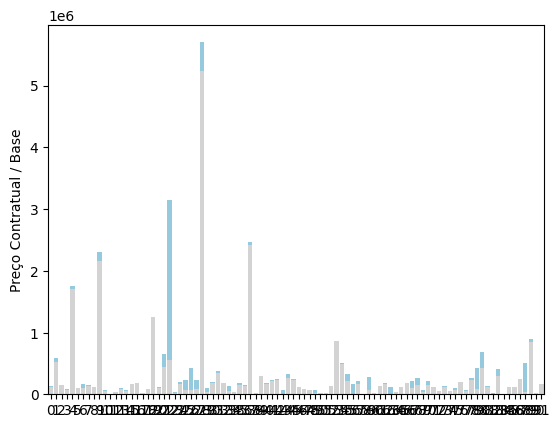

In [287]:
df = contratos(cpub).iloc[:,[2,18]]
df = df.rename(columns={2: 'PrecoBase', 18:'PrecoContratual'})
df = df.astype('float')

sns.barplot(x = df.index, y = df.PrecoBase, color = 'skyblue')
sns.barplot(x = df.index, y = df.PrecoContratual, color = 'lightgray', fill=0.1)
plt.ylabel('Preço Contratual / Base')
plt.show()

- preco final e preco base : fazer o sumario deste array de valores, ver outliers e tal

- distribuição dos dois preços e da diferença

- arranjar plot : organizar dados por mes/ano dependendo do span

- testes de hipóteses para distribuições

- categorizar range dos precos em 3 intervalos p. ex.

In [308]:
#print(np.where(pb/pc > 400))

HTML(contrato(cpub[22]).to_html(index=False))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10332117,8223/2023,3139486.56,30,False,6506218,13041258,2023-05-22,98,2,False,False,https://dre.pt/application/file/213330772,Anúncio de procedimento,Concurso público,Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação,2023-11-08,2023-11-03,557776.80,420,"SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)","Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos","Sys-Match - Consultores de Sistemas de Informação, Lda (504665901)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=323846)","IDW - Consultoria em Serviços de Informação, Lda (504243926)|||INDRA III SOLUÇÕES TECNOLOGIA (TECNOCOMPORT) (503222364)|||Capgemini Portugal, S.A. (504272179)|||Accenture - Consultores de Gestão, S.A. (502309440)|||NOS - Comunicações S.A. (502604751)|||MARCOS BARROSA, UNIPESSOAL LDA (515371378)|||WINNING, LDA. (510098711)|||HLTSYS - HEALTHSYSTEMS, LDA (510552544)|||IGNIT PEOPLE , S.A. (515777048)|||AXIANSEU II DIGITAL CONSULTING, S.A. (501774360)",https://www.base.gov.pt/Base4/pt/detalhe/?type=anuncios&id=347532,https://community.vortal.biz/PRODPublic/Tendering/OpportunityDetail/Index?noticeUID=PT1.NTC.2397171,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2072887&ext=.pdf,false,72500000-0,False,None,None,True,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com a informática,Principal,557776.8,Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação,Não aplicável,None,"Portugal, Lisboa<BR/>Portugal, Porto",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",Plano de Recuperação e Resiliência (PRR) – artigo 6º da Lei n.º30/2021,None,1699503091


In [228]:
redflag(pb, pc, 0.1, cpub, 20)

/tmp/ipykernel_51033/4280521597.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = pbase[i] / pcontr[i]


(('10324626',),
 ('10325177',),
 ('10270503',),
 ('10326579',),
 ('10270055',),
 ('10271560',),
 ('10271100',),
 ('10273652',),
 ('10273546',),
 ('10273533',),
 ('10273490',),
 ('10285558',),
 ('10332117',),
 ('10281794',),
 ('10281471',),
 ('10280375',),
 ('10280297',),
 ('10284270',),
 ('10286838',),
 ('10285595',),
 ('10288280',),
 ('10291509',),
 ('10290955',),
 ('10293359',),
 ('10292066',),
 ('10296443',),
 ('10295857',),
 ('10295337',),
 ('10295167',),
 ('10299255',),
 ('10297408',),
 ('10297391',),
 ('10300291',),
 ('10307301',),
 ('10306289',),
 ('10308597',),
 ('10307803',),
 ('10312461',),
 ('10333899',),
 ('10333427',),
 ('10333165',))

***

# Ajuste Direto Regime Geral

***

In [229]:
ajustesdir = contratos(ajdir)
ajustesdir = ajustesdir.rename(columns={18:'PrecoContratual', 38:'TipoProcedimento'})

ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count        296.00
mean       46413.11
std       215696.96
min          300.00
25%         7825.50
50%        14590.00
75%        19990.00
max      3415500.00
Name: PrecoContratual, dtype: object

In [230]:
#HTML(ajustesdir.to_html(index = False))

In [232]:
# Valor máximo de um ajuste direto é mais de 3.000.000,00€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 3000000)[0])

# ID do contrato correspondente
# ajdir[30]

HTML((contrato(ajdir[30])).to_html(index=True))

[30]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,10323555,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,2023-11-02,2023-11-02,3415500.00,1096,"Instituto de Informática, I. P. (504322915)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1957)","Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos","UNISYS, S.L.U. (B-82538273)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1152098)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071204&ext=.pdf,false,72200000-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de consultoria e de programação de software,Principal,3415500.0,2323000197 - Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,Não aplicável,None,"Portugal, Lisboa, Oeiras",Não aplicável.,Não aplicável.,None,False,False,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382506


In [233]:
k = 0
for i in range(len(ajustesdir)):
    
    if ajustesdir.TipoProcedimento[i] == 'Aquisição de serviços':
        #print(i, True, ajustesdir.TipoProcedimento[i])

        
        if ajustesdir.PrecoContratual[i] > 20000:
            k += 1

print(k)
    #print(ajustesdir.TipoProcedimento)

64


In [234]:
# Valores dos preços contratuais
#contratos(redflag2(ajustesdir, ajdir)).iloc[:,18]

# Ajustes Diretos com preço contratual superior a 20.000€
contratos(redflag2(ajustesdir, ajdir))

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
1,10324999,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 2, a), a segurança pública in...",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385859
2,10326178,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017 )...,None,24775.00,1699384995
3,10326176,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384999
4,10270868,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,None,Código dos Contratos Públicos (DL 111-B/2017 )...,None,None,1699468591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10309658,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699566441
61,10309059,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699567160
62,10308934,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017 )...,None,None,1699567301
63,10333806,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699589564
